# Gauss-Newton for XRD

In [106]:
from XRDXRFutils import GaussNewton,DataXRD,SpectraXRD,DatabaseXRD,PhaseList

from matplotlib.pyplot import xlim,ylim,xlabel,ylabel,legend,plot,fill_between,imshow,subplots,sca
from numpy import prod,array,minimum,maximum,log,zeros,trapz,where
from multiprocessing import Pool

### loading data

In [135]:
path = '/home/zdenek/Projects/pyMaXRDXRF/M491/ProfiloXRD/'


data = DataXRD().load_h5(path + 'data.h5')
data.opt = [-1186.6, 1960.3, 51]

database = DatabaseXRD().read_cifs('/home/zdenek/Projects/XRDXRFutils/Database')

lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][0]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]

phases = PhaseList([hydrocerussite,lazurite,cinnabar])

Loading: /home/zdenek/Projects/pyMaXRDXRF/M491/ProfiloXRD/data.h5


In [136]:
class PhaseSearch(list):
    """
    Class to perform phase search.
    """
    def __init__(self,phases,spectra):
        super().__init__([GaussNewton(phase,spectra) for phase in phases])
        
        self.spectra = spectra
        self.intensity = spectra.intensity
        
        self.opt = self[0].opt
        for g in self:
            g.opt = self.opt
        
    def minimize_gamma(self,n=4):
        for g in self:
            for i in range(n):
                g.minimize_gamma()
                
    def overlap_area(self):
        return array([g.overlap_area() for g in self])
    
    def loss(self):
        return array([g.loss() for g in self])
    
    def select(self):
        idx = self.overlap_area().argmax()
        selected = self[idx]
        
        self.idx = idx
        self.selected = selected
        
        return selected
    
    def theta_correction(self,n=4):
        for i in range(n):
            self.select().calibration()
            
    def search(self):
        
        self.minimize_gamma()
        self.select()

        self.theta_correction()
        self.minimize_gamma()
        
        return self
    
class PhaseMap(list):
    """
    Class to process images
    """      
    def from_data(self,data,phases):
    
        phases.get_theta(max_theta=53,min_intensity=0.05)
        arr = data.data.reshape(-1,1280)

        spectras = self.gen_spectras(arr)        
        for spectra in spectras:
            spectra.opt = [-1186.6, 1960.3, 51]
        
        self += [PhaseSearch(phases,spectra) for spectra in spectras]
        
        return self
    
    @staticmethod
    def f_spectra(x):
        return SpectraXRD().from_array(x)

    def gen_spectras(self,a):
        with Pool() as p:
            spectras = p.map(self.f_spectra,a)
        return spectras
    
    @staticmethod
    def f_search(x):
        return x.search()
    
    def search(self):
        with Pool() as p:
            result = p.map(self.f_search,self)
        return PhaseMap(result)

In [137]:
%%time
pm = PhaseMap().from_data(data,phases)

CPU times: user 2.81 s, sys: 2.03 s, total: 4.84 s
Wall time: 4.57 s


In [138]:
%%time
result = pm.search()

CPU times: user 8.86 s, sys: 2.75 s, total: 11.6 s
Wall time: 56.1 s


[-1183.7162984071156, 1950.8523660988535, 51]


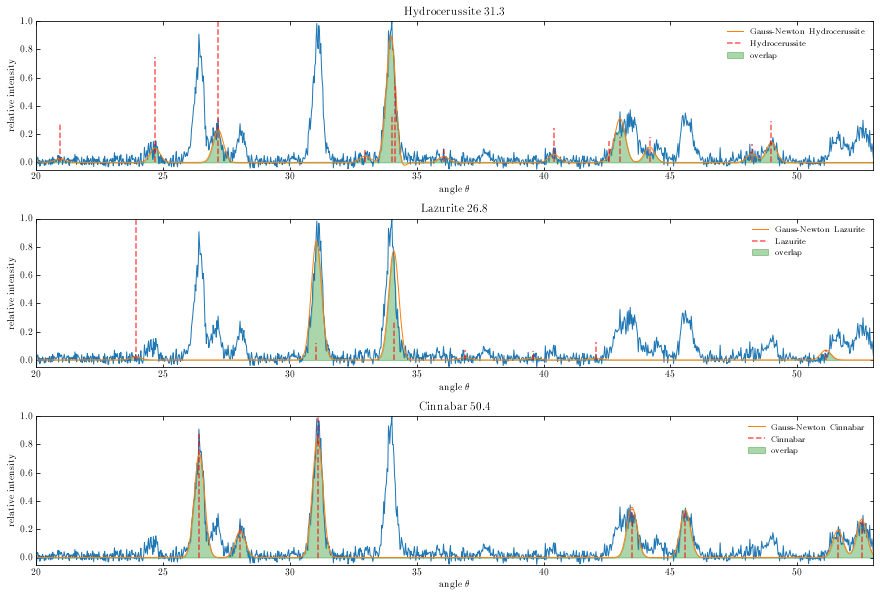

In [140]:
r = result[1600]

fig,ax = subplots(len(r),1,figsize=(15,10))
fig.subplots_adjust(hspace=0.33)
print(r.opt)
                  
for i,g in enumerate(r):
    
    sca(ax[i])
    
    ax[i].set_title('%s %.1f'%(g.label,g.overlap_area()))
    g.plot_spectra(lw=1)
    g.plot('-',label='Gauss-Newton %s'%g.label,lw=1)
    g.phase.plot('r',alpha=0.66)

    fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

    legend(frameon=False)
    ylim(-0.05,1)
    xlim(20,53)
    xlabel(r'angle $\theta$')
    ylabel(r'relative intensity')

## Calibration

per pixel calibration dependence

a,b: [  -0.43302646 -337.55905346] [ -0.81903454 418.921718  ]
-1186.7218964464705 1960.9952933343511


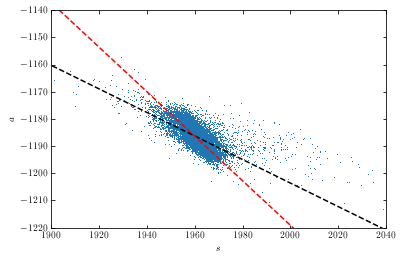

In [141]:
%matplotlib inline
from numpy import linspace
from scipy.optimize import curve_fit,least_squares
def f(x,a,b):
    return a*x + b
def loss(x,t,y):
    return (x[0]*t + x[1]) - y

a = array([r.selected.opt[0] for r in result])
s = array([r.selected.opt[1] for r in result])
x = linspace(s.min(),s.max())

opt,var = curve_fit(f,s,a)

res = least_squares(loss,x0=opt,args=(s,a),loss='cauchy')
print('a,b:',opt,res['x'])

linear_y = f(x,*opt)
cauchy_y = f(x,*res['x'])

plot(s,a,',')
plot(x,linear_y,'k--')
plot(x,cauchy_y,'r--')

xlabel(r'$s$')
ylabel(r'$a$')
xlim(1900,2040)
ylim(-1220,-1140)

print(a.mean(),s.mean())

## Pair compositions

In [164]:
r = result[1600]
n = len(r)
A = zeros((n,n))

for i,ra in enumerate(r):
    print(i,i,ra)
    for j,rb in enumerate(r[i+1:]):
        print(i,j+1,rb)

0 0 <XRDXRFutils.gaussnewton.GaussNewton object at 0x7f3652ab0d90>
0 1 <XRDXRFutils.gaussnewton.GaussNewton object at 0x7f36402d4940>
0 2 <XRDXRFutils.gaussnewton.GaussNewton object at 0x7f36402d4a00>
1 1 <XRDXRFutils.gaussnewton.GaussNewton object at 0x7f36402d4940>
1 1 <XRDXRFutils.gaussnewton.GaussNewton object at 0x7f36402d4a00>
2 2 <XRDXRFutils.gaussnewton.GaussNewton object at 0x7f36402d4a00>


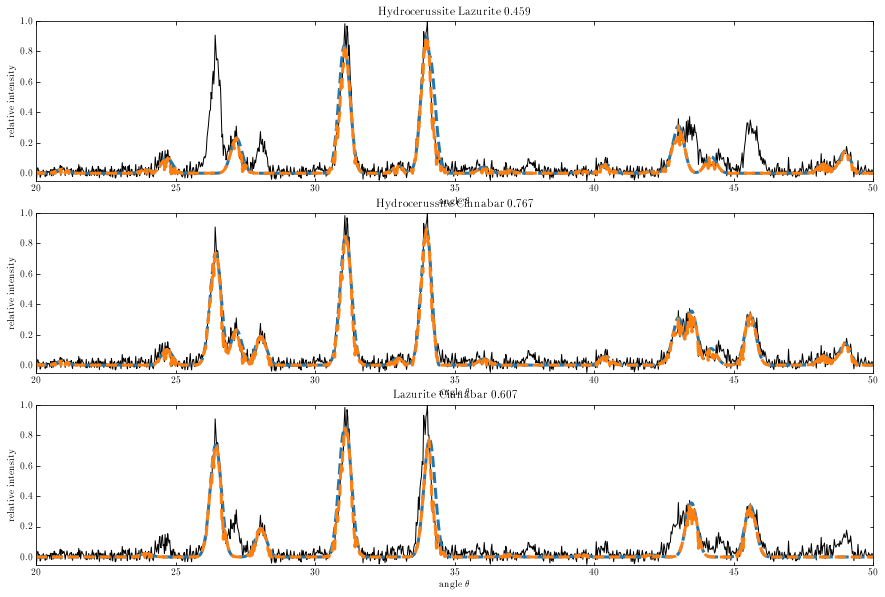

In [143]:
g_list = r
n = int(len(g_list)*(len(g_list)-1)/2)

fig,ax = subplots(n,1,figsize=(15,10))

k = 0
for i,ga in enumerate(g_list):
    for j,gb in enumerate(g_list[i+1:]):
        
        sca(ax[k])       
        c = maximum(ga.z(),gb.z())
        d = minimum(c,ga.intensity)
        d[d<0] = 0
        ss = ga.intensity.copy()
        ss[ss<0] = 0
        ss = trapz(ss)
        dd = trapz(d)
        #print(dd,ss,dd/ss)
        
        A[i,i+j+1] = dd/ss
        
        ax[k].plot(ga.theta,ga.intensity,'k',lw=1)
        ax[k].plot(gb.theta,c,'--',lw=3)
        ax[k].plot(gb.theta,d,'--',lw=3)

        #ax[k].legend(frameon=False)
        ax[k].set_title('%s %s %.3lf'%(ga.label,gb.label,dd/ss))
        ax[k].set_ylim(-0.05,1)
        ax[k].set_xlim(20,50)
        ax[k].set_xlabel(r'angle $\theta$')
        ax[k].set_ylabel(r'relative intensity')
                
        k += 1

In [145]:
A = zeros((3,3))

k = 0
for i,ga in enumerate(g_list):
    for j,gb in enumerate(g_list):
            
        c = maximum(ga.z(),gb.z())
        d = minimum(c,ga.intensity)
        d[d<0] = 0
        ss = ga.intensity.copy()
        ss[ss<0] = 0
        ss = trapz(ss)
        dd = trapz(d)
        
        A[i,j] = dd/ss
        
A

array([[0.30213149, 0.45935291, 0.7667094 ],
       [0.45935291, 0.25941746, 0.60682427],
       [0.7667094 , 0.60682427, 0.48682365]])

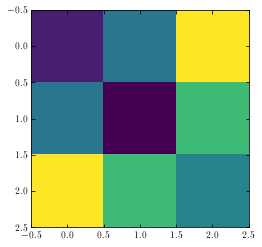

In [146]:
imshow((A))

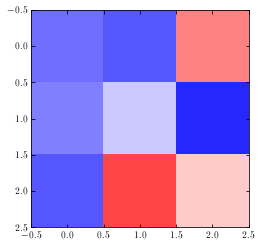

In [147]:
from numpy.linalg import eig,svd,qr,cholesky,pinv,eigvals,det,inv
v,vec = eig(A)
imshow(vec,cmap='bwr',vmin=-1,vmax=1)

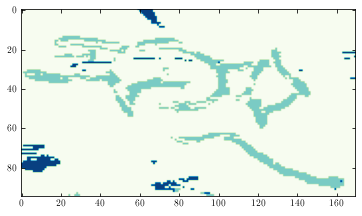

In [148]:
%matplotlib inline
idx = array([r.idx for r in result]).reshape(95,170)
imshow(idx,cmap='GnBu')

In [149]:
%%time
area = array([r.overlap_area() for r in result])
loss = array([r.loss() for r in result])
ss = array([trapz(r.spectra.intensity) for r in result])

CPU times: user 21 s, sys: 791 µs, total: 21 s
Wall time: 21 s


In [150]:
area = area.reshape(95,170,-1)
loss = loss.reshape(95,170,-1)
ss = ss.reshape(95,170)

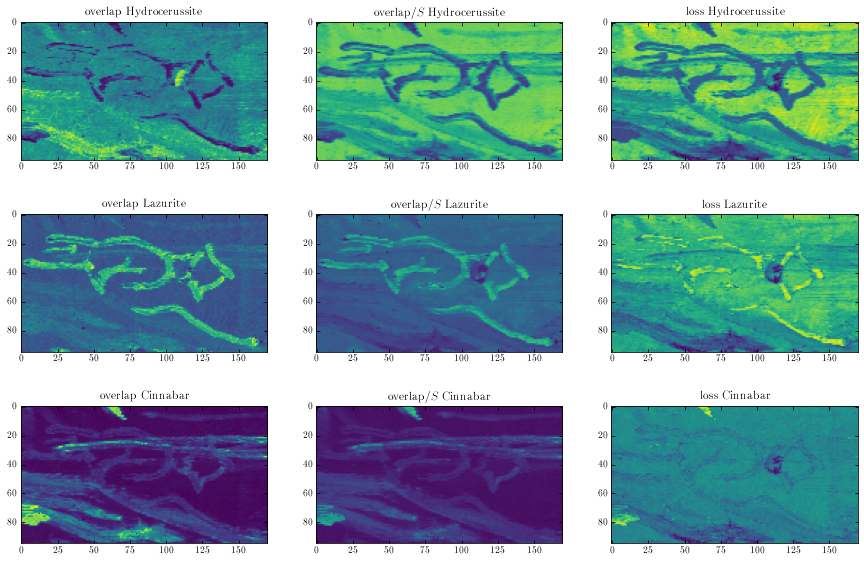

In [158]:
fig,ax = subplots(3,3,figsize=(15,10))

for i,g in enumerate(g_list):
    
    ax[i,0].imshow(area[:,:,i])
    ax[i,1].imshow(area[:,:,i]/ss,vmin=0,vmax=1)
    
    ax[i,2].imshow(-log(loss[:,:,i]))
    
    ax[i,0].set_title(r'overlap %s'%g.label)
    ax[i,1].set_title(r'overlap/$S$ %s'%g.label)
    ax[i,2].set_title(r'loss %s'%g.label)